In [10]:
import os, sys
import numpy as np
top_dir = os.getcwd().split('v4cnn')[0];sys.path.append(top_dir+ 'v4cnn/')
sys.path.append( top_dir + 'xarray');top_dir = top_dir + 'v4cnn/';sys.path.append( top_dir + 'common/')
sys.path.append(top_dir +'/nets')
import matplotlib
from matplotlib.ticker import FuncFormatter
import pickle
import xarray as xr;import pandas as pd
import apc_model_fit as ac
import matplotlib.ticker as mtick;import matplotlib.pyplot as plt;import matplotlib.cm as cm
import d_plot as dp
import scipy.io as  l
import caffe_net_response as cf
%matplotlib inline  


<h3>Stimuli.</h3>

max: 255.0 min:0.0


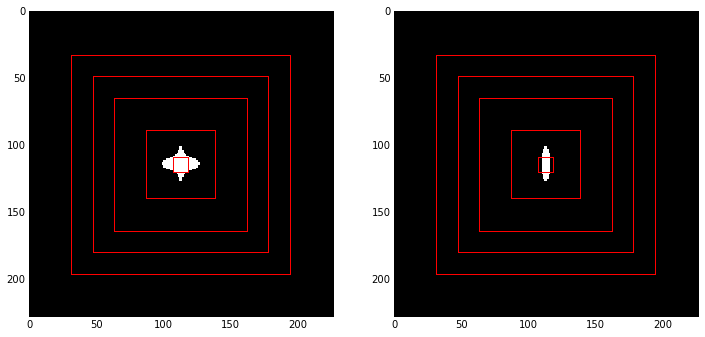

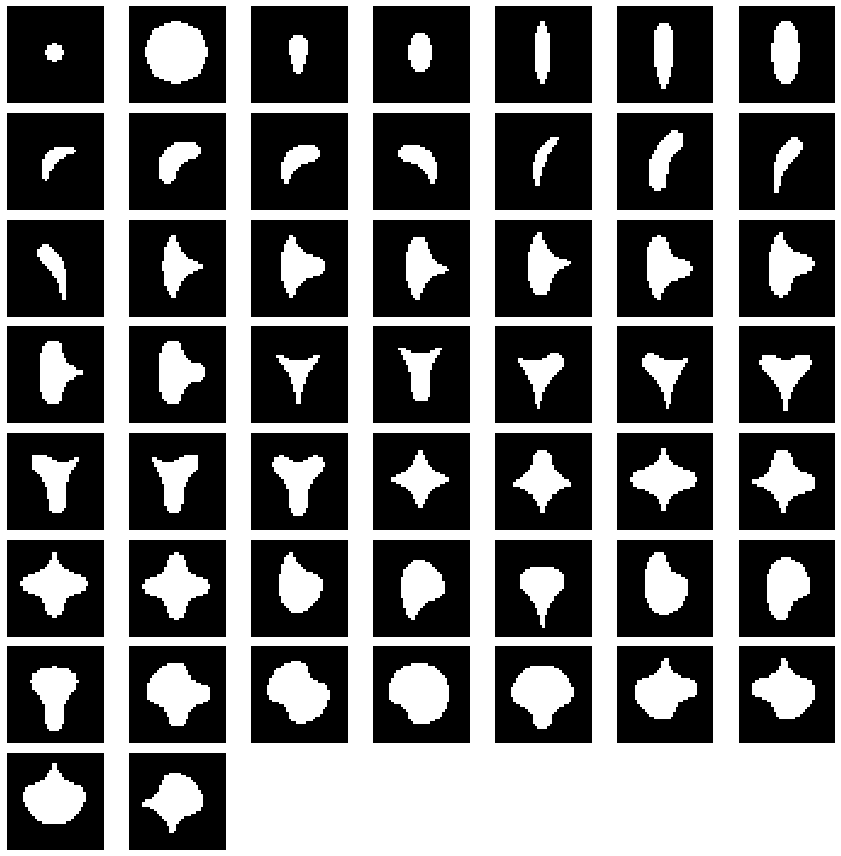

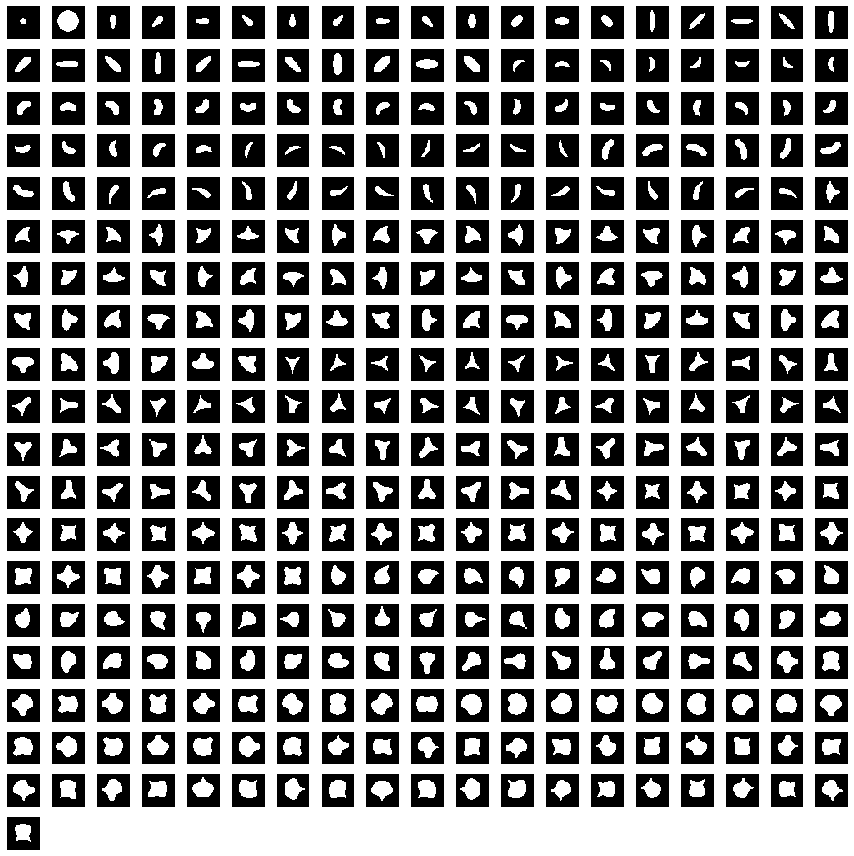

In [11]:
import d_curve as dc
import caffe_net_response as cf
import d_img_process as imp

box_lengths = [11,51,99,131,163]#taking from wyeths CaffeNet figure
img_n_pix = 227
max_pix_width = [32.,]

s = l.loadmat(top_dir + 'img_gen/PC3702001ShapeVerts.mat')['shapes'][0]
base_stack = dc.center_boundary(s)

boundaries = imp.center_boundary(s)
scale = max_pix_width/dc.biggest_x_y_diff(boundaries)
shape_ids = range(-1, 370); center_image = round(img_n_pix/2)
x = (center_image, center_image, 1);y = (center_image, center_image, 1)
stim_trans_cart_dict, stim_trans_dict = cf.stim_trans_generator(shapes=shape_ids, scale=scale, x=x, y=y)
plt.figure(figsize=(12,24));
center = 113

trans_img_stack = np.array(imp.boundary_stack_transform(stim_trans_cart_dict, base_stack, npixels=227))
#plot smallest and largest shape
no_blank_image = trans_img_stack[1:]
extents = (no_blank_image.sum(1)>0).sum(1)
plt.subplot(121)
plt.imshow(no_blank_image[np.argmax(extents)],
                          interpolation = 'nearest', cmap=plt.cm.Greys_r)
for box_length in box_lengths:
    rectangle = plt.Rectangle((center-np.ceil(box_length/2.), center-np.ceil(box_length/2)),
                               box_length, box_length, fill=False, edgecolor='r')
    plt.gca().add_patch(rectangle)
plt.subplot(122)
plt.imshow(no_blank_image[np.argmin(extents)],
                          interpolation = 'nearest', cmap=plt.cm.Greys_r)
for box_length in box_lengths:
    rectangle = plt.Rectangle((center-np.ceil(box_length/2.), center-np.ceil(box_length/2)),
                               box_length, box_length, fill=False, edgecolor='r')
    plt.gca().add_patch(rectangle)

a = np.hstack((range(14), range(18,318)));a = np.hstack((a, range(322, 370)))
aperture = 20
plt.figure(figsize=(12,12))
no_rotation = [0, 1, 2, 10,14, 18, 26,30, 38, 46, 54, 62, 70, 78, 86, 94,102, 110, 118, 126, 134,
 142, 150, 158,166, 174, 182, 190,198, 206, 214, 222, 224, 232, 236, 244, 252, 254, 
 262, 270, 278, 286, 294, 302, 310, 314, 322, 330, 338, 346, 354, ]
for i, a_shape in enumerate(no_blank_image[a][no_rotation]):
    plt.subplot(8,7,i+1)
    plt.imshow(a_shape, interpolation = 'nearest', cmap=plt.cm.Greys_r)
    plt.xlim([center-aperture, center+aperture]);plt.ylim([center-aperture, center+aperture])
    plt.xticks([]);plt.yticks([])
plt.tight_layout()


plt.figure(figsize=(12,12))
for i, a_shape in enumerate(no_blank_image[a]):
    plt.subplot(20,19,i+1)
    plt.imshow(a_shape, interpolation = 'nearest', cmap=plt.cm.Greys_r)
    plt.xlim([center-aperture, center+aperture]);plt.ylim([center-aperture, center+aperture])
    plt.xticks([]);plt.yticks([])
plt.tight_layout()

print('max: '+str(np.max(no_blank_image[a]))
            + ' min:' + str(np.min(no_blank_image[a])))

Typical images entering CaffeNet have the pixelwise mean of the entire ImageNet database subtracted from them, here we do not subtract this mean as it prevents the shapes from being compact, i.e. there would be variance all over the image because the mean has variance all over the image. 

In [12]:
v4_name = 'V4_362PC2001'
v4_resp_apc = xr.open_dataset(top_dir + 'data/responses/' + v4_name + '.nc')['resp'].load()
v4_resp_apc = v4_resp_apc.transpose('shapes', 'unit')
with open(top_dir + 'data/an_results/fixed_relu_saved_24_30_pix.p', 'rb') as f:
    pan = pickle.load(f)
pda = pan['24']

<h3>Sparsity.</h3>
We observed responses of CaffeNet both to our stimuli could be quite limited. Many units in the rectified layers of CaffeNet did not respond to any stimuli at any position or only several. Typical fits of the APC model predict rich tuning across shapes. In addition very sparse responses pose  a problem for our measure of translation invariance where if the unit only responds to one shape, then it trivially achieves perfect translation invariance. For these reasons we sought a measure of sparsity along which to filter for units with the range of sparsity seen for real V4 cells.
We considered a few different metrics of sparsity

A first choice was the coefficient of variation:
$$C = \frac{\sigma}{\mu}$$

and the variant made by Treves and Rolls that scales it between 0 and 1:

$$T = \frac{1}{C^2 + 1}$$

These were well suited to rectified layers of CaffeNet but for other layers such as FC8 where there were negative values did not work, as the measure was designed for positive distributions.

We also considered the Gini Coefficient but it suffered from the same problem.

We settled on kurtosis:

$$K = \frac{(x-\mu)^4}{n \sigma^4}$$

For a gaussian distribution $K=3$.

E T Rolls, M J Tovee, 1995, Sparseness of the neuronal representation of stimuli in the primate temporal visual cortex, Journal of Neurophysiology, 73(2):713-726.
D J Field, 1994, What is the goal of sensory coding?, Neural Computation, 6:559-601.

In [13]:
def kurtosis_unit(unit):
    mu = np.mean(unit)
    sig = np.std(unit)
    k = (np.sum(((unit - mu)**4)))/((sig**4)*len(unit))
    return k
def kurtosis(da):
    da = da.transpose('shapes', 'unit')
    mu = da.mean('shapes')
    sig = da.reduce(np.nanvar, dim='shapes')
    k = (((da - mu)**4).sum('shapes', skipna=True) / da.shapes.shape[0])/(sig**2)
    return k

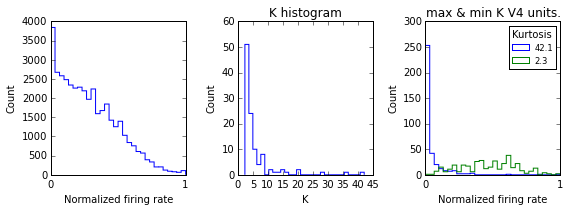

In [14]:
k_apc = kurtosis(v4_resp_apc).values

plt.figure(figsize=(8,3))
plt.subplot(131)
plt.hist(v4_resp_apc.values.ravel(),bins=30,histtype='step')
plt.xlabel('Normalized firing rate');plt.ylabel('Count');plt.xticks([0,1])



plt.subplot(132)
plt.hist(k_apc, bins=30, histtype='step')
plt.xlabel('K');plt.ylabel('Count');plt.title('K histogram')

plt.subplot(133)
plt.hist(v4_resp_apc[:, np.argmax(k_apc)], bins=30, log=False, normed=False, histtype='step',  range=[0,1])
plt.hist(v4_resp_apc[:, np.argmin(k_apc)], bins=30,log=False, normed=False, histtype='step', range=[0,1])
plt.legend(np.round([np.max(k_apc), np.min(k_apc)],1), 
           title='Kurtosis', loc=1, fontsize='small')
plt.xlabel('Normalized firing rate');plt.ylabel('Count');plt.xticks([0,1])


plt.title('max & min K V4 units.')
plt.tight_layout();plt.show();



From left to right. 
1. Here we see the data is normalized to one with a tendency towards lower values. 
2. We find our k-distribution is sparse with most units having a low k, but a few particularly sparse one.
3. Plotting the response distribution of the units with highest and lowest k gives us a sense for what k measures, and the range of distributions.

Lets see how this compares to the values measured for CaffeNet layers

sparsest possible = 369.002702703
max sparsity=369.018615723


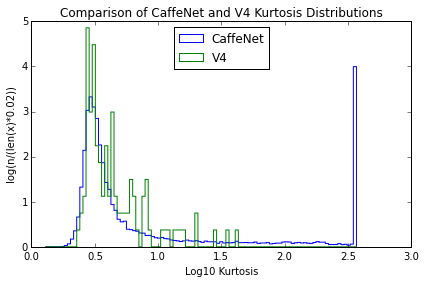

In [15]:
plt.hist(np.log10(pda['k'].dropna()),  bins=100, histtype='step', normed=True,
         range=np.log10([min(pda['k']), max(pda['k'])]), color='b')

_, bins, patches = plt.hist(np.log10(k_apc), bins=100, histtype='step',normed=True,
         range=np.log10([min(pda['k']), max(pda['k'])]), color='g')
dbin = bins[1]-bins[0]
plt.xlabel('Log10 Kurtosis')
plt.ylabel('log(n/(len(x)*'+str(np.round(dbin,2)) + '))')
plt.title('Comparison of CaffeNet and V4 Kurtosis Distributions')
plt.legend(['CaffeNet','V4'], loc=9)
plt.tight_layout()

sparsest_unit = np.zeros((371,1))
sparsest_unit[0] = 1
k=kurtosis_unit(sparsest_unit)
print('sparsest possible = '+ str(k))
print('max sparsity=' + str(max(pda['k'])))

Looking at kurtosis values across all layers of CaffeNet in comparison to V4 units for the APC 362 stimuli, we see CaffeNet has higher values of sparsity. The peak at the right of the distribution is near the max value kurtosis can take on for this number of entries, i.e. CaffeNet only responded to one shape. I print out the kurtosis of a hypothetical unit with only 1 response, it is a little lower, later I can look into this.
In subsequent analysis we only include units from CaffeNet with a kurtosis of less than log10(42) = 1.62

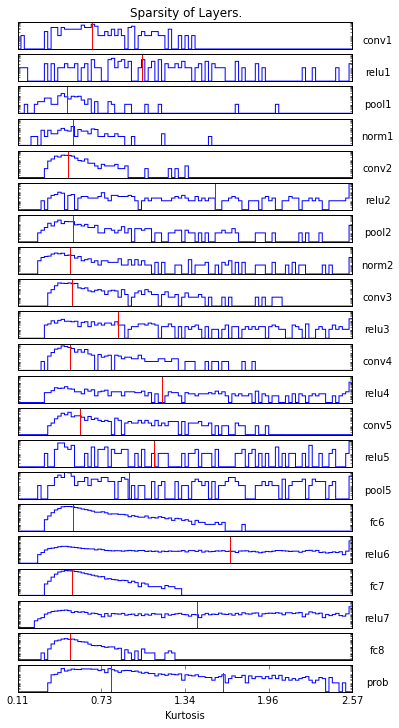

In [16]:
plt.figure(figsize=(6, 12))
title = 'Sparsity of Layers.'
dp.stacked_hist_layers(pda['k'].dropna(), logx=True, logy=True,
                    xlim=[min(pda['k']), max(pda['k']+5)],
                    maxlim=False, bins=100, title=title)
plt.plot([np.log10(max(k_apc)),]*2,[0,12])
plt.xlabel('Kurtosis')

Red lines indicate medians. Rectified layers unsurprisingly tend to be much more sparse with far higher medians.
We can see that this threshold, in green at the bottom of the plot.

<h3>APC fit.</h3>

The angular position and curvature (APC) model was built to describe the responses of V4-cells to 52 unique shapes, and their rotations totaling 362 unique images.  

In [21]:
import apc_model_fit as ac
if 'dmod' not in locals():
    fn = top_dir + 'data/models/' + 'apc_models_362.nc'
    dmod = xr.open_dataset(fn, chunks={'models': 50, 'shapes': 370}  )['resp'].load()
    apc_fit = ac.cor_resp_to_model(v4_resp_apc.chunk({'shapes': 370}), dmod.chunk({}), fit_over_dims=None, prov_commit=False)
    apc_fit = apc_fit**2
    cnn_names =['APC362_deploy_fixing_relu_saved.prototxt_fixed_even_pix_width[24.0, 30.0]_pos_(64.0, 164.0, 51)bvlc_reference_caffenet' ]
    cnn = xr.open_dataset(top_dir + 'data/responses/' + cnn_names[0] + '.nc')['resp'].isel(scale=1)
    cnn = cnn.sel(x=114)
    cnn = cnn.sel(unit=slice(None,None, 20)).load()
apc_fit_cnn = ac.cor_resp_to_model(cnn.squeeze().chunk({'shapes': 370}), dmod.chunk({}), fit_over_dims=None, prov_commit=False)**2

print('Mean Orientation (radians): ' + str(np.round(np.unique(dmod.coords['models'].or_mean.values),2)))
print('SD Orientation (radians): '+ str(np.round(np.unique(dmod.coords['models'].or_sd.values),2)))
print('Mean Curvature: ' + str(np.round(np.unique(dmod.coords['models'].cur_mean.values),2)))
print('SD Curvature: ' +str(np.round(np.unique(dmod.coords['models'].cur_sd.values),2)))

Mean Orientation (radians): [ 0.    0.39  0.79  1.18  1.57  1.96  2.36  2.75  3.14  3.53  3.93  4.32
  4.71  5.11  5.5   5.89]
SD Orientation (radians): [ 0.4   0.46  0.52  0.6   0.69  0.78  0.9   1.02  1.17  1.34  1.53  1.75
  2.    2.28  2.61  2.98]
Mean Curvature: [-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
  1. ]
SD Curvature: [ 0.09  0.11  0.12  0.15  0.17  0.2   0.23  0.27  0.32  0.38  0.44  0.52
  0.61  0.71  0.84  0.98]


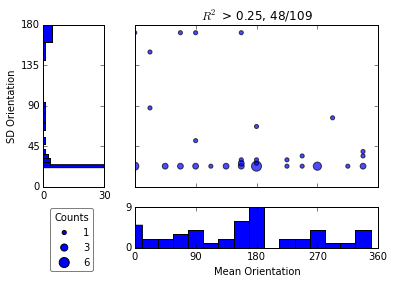

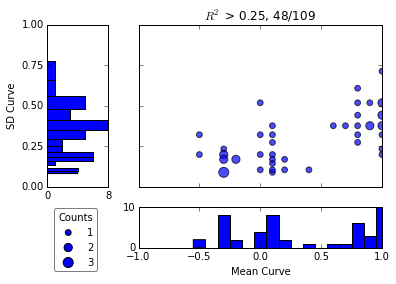

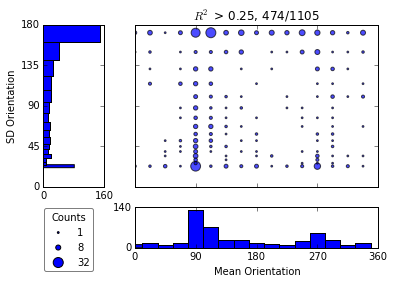

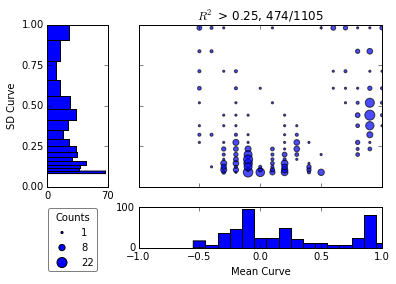

In [23]:
ybins_cur = dp.correct_bins_for_hist(np.unique(dmod.coords['cur_sd']))
xbins_cur = dp.correct_bins_for_hist(np.unique(dmod.coords['cur_mean']))
ybins_or = dp.correct_bins_for_hist(np.unique(dmod.coords['or_sd'].values/(2*np.pi))*360)
xbins_or = dp.correct_bins_for_hist((((np.unique(dmod.coords['or_mean'].values)/(2*np.pi))*360)%360))

rthresh = 0.25
the_fits = 

thresh_fits = apc_fit[apc_fit>rthresh]

tot = len(apc_fit.values)
ncell = len(thresh_fits['unit'])
title = '$R^2$ > ' + str(rthresh) + ', ' + str(ncell) + '/' + str(tot)

thresh_fits.coords['or_mean'] = ((thresh_fits.coords['or_mean']/(2*np.pi))*360)%360
thresh_fits.coords['or_sd'] = ((thresh_fits.coords['or_sd']/(2*np.pi))*360)

fig = dp.scatter_w_marginals(thresh_fits.coords['or_mean'].values, 
                             thresh_fits.coords['or_sd'].values,
                    'Mean Orientation', 'SD Orientation',
                    xlim= [0, 360],
                    #ylim= [0, np.round(np.max(threshFits['or_sd'] )+1,-1)],
                    ylim = [0, 180],
                    title = title,
                    ybins=ybins_or,
                    xbins=xbins_or)
plt.show()

fig = dp.scatter_w_marginals(thresh_fits.coords['cur_mean'].values, 
                             thresh_fits.coords['cur_sd'].values,
                    'Mean Curve', 'SD Curve',
                    xlim= [-1, 1],
                    ylim= [0, np.round(np.max(thresh_fits['cur_sd']),0).values],
                    title = title,
                    ybins=ybins_cur,
                    xbins=xbins_cur)
plt.show()

thresh_fits = apc_fit_cnn[apc_fit_cnn>rthresh]

tot = len(apc_fit_cnn.values)
ncell = len(thresh_fits['unit'])
title = '$R^2$ > ' + str(rthresh) + ', ' + str(ncell) + '/' + str(tot)

thresh_fits.coords['or_mean'] = ((thresh_fits.coords['or_mean']/(2*np.pi))*360)%360
thresh_fits.coords['or_sd'] = ((thresh_fits.coords['or_sd']/(2*np.pi))*360)

fig = dp.scatter_w_marginals(thresh_fits.coords['or_mean'].values, 
                             thresh_fits.coords['or_sd'].values,
                    'Mean Orientation', 'SD Orientation',
                    xlim= [0, 360],
                    #ylim= [0, np.round(np.max(threshFits['or_sd'] )+1,-1)],
                    ylim = [0, 180],
                    title = title,
                    ybins=ybins_or,
                    xbins=xbins_or)
plt.show()

fig = dp.scatter_w_marginals(thresh_fits.coords['cur_mean'].values, 
                             thresh_fits.coords['cur_sd'].values,
                    'Mean Curve', 'SD Curve',
                    xlim= [-1, 1],
                    ylim= [0, np.round(np.max(thresh_fits['cur_sd']),0).values],
                    title = title,
                    ybins=ybins_cur,
                    xbins=xbins_cur)
plt.show()



A goal of visual neuroscience is to develop image computable models of units in the visual stream. Many well defined properties of units further along the ventral stream have been known for years, for example invariance to image transformation, and object selectivity, yet image computable models have unsurprisingly had difficulty in these areas, because these properties are unsolved problems in computer vision. Thus it was difficult to imagine accounting for neural responses with an image computable model until recently
CNN's trained on object recongition tasks have been able to account for roughly half the variance of units in IT and V4 responding to natural images. Unfortunately these models are not easily interpretable in part because the numbers of parameters is very high and so what about these response properties they explain is unknown.
A model that is not image computable, the angular position and curvature model, captures the observation that cells in V4 are senstive to the boundary curvature of closed shapes at particular positions around the shape. Additionally implicit in the model is that these responses are invariant to the position of the object, a well known property of V4. 
We sought to measure the degree to which a convolutional neural net could serve as an image computable model that captures these published properties. The spirit of the analysis was to ask whether an electrophysiologist recording from a unit in the convolutional neural would determine units in the CNN to be V4-like in this way.